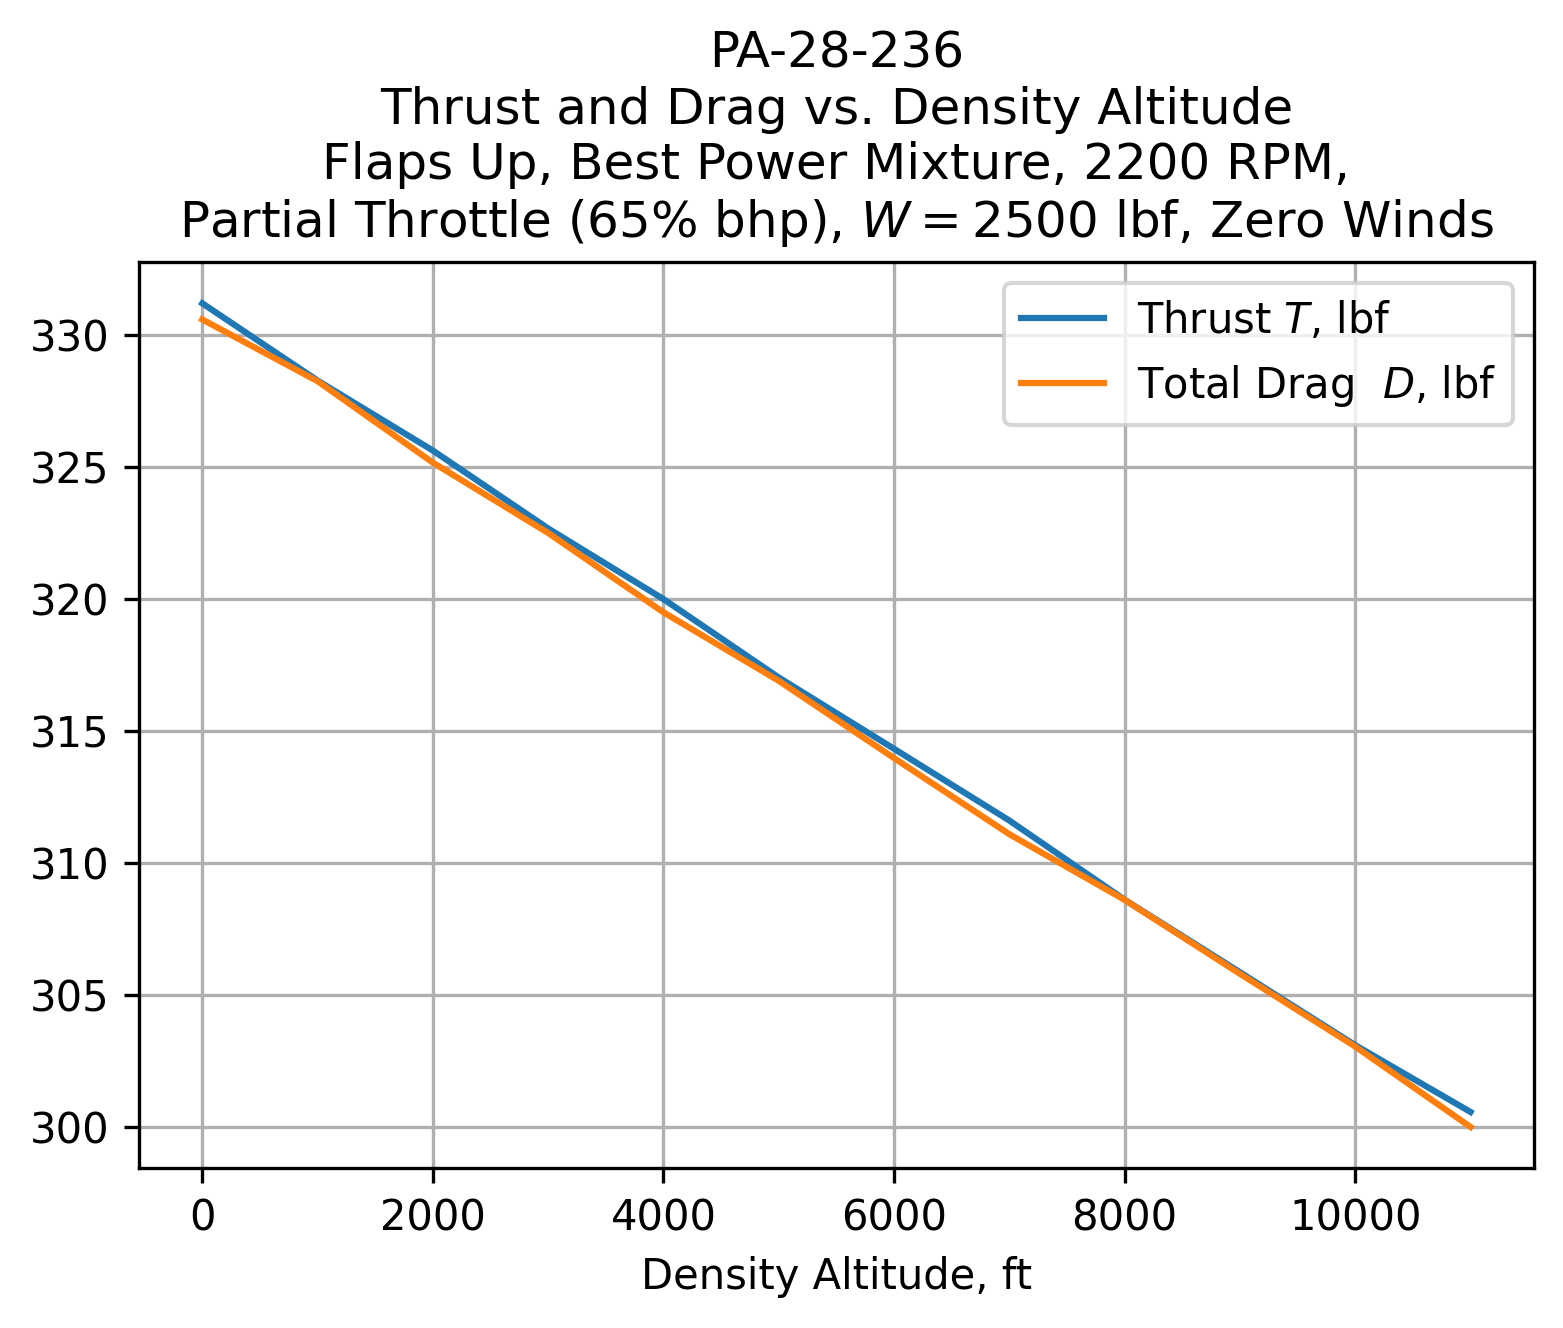

In [9]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from n51sw_dataplate import N51SW
from the_bootstrap_approach.conditions import PartialThrottleConditions
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.mixture import Mixture
from the_bootstrap_approach.performance import (
    bootstrap_cruise_performance_table,
    ByKCASRowIndex,
)


def thrust_drag_vs_altitude(mixture, gross_aircraft_weight):
    thrust = []
    drag = []

    by_altitude_table = []

    x = np.arange(0, 12000, 1000)

    for pressure_altitude in x:
        oat_f = british_standard_temperature(pressure_altitude)

        table = bootstrap_cruise_performance_table(
            N51SW,
            PartialThrottleConditions(
                N51SW,
                gross_aircraft_weight,
                pressure_altitude,
                oat_f,
                mixture,
                2200,
                N51SW.rated_full_throttle_engine_power * 0.65,
            ),
            60,
            180,
            0.1,
        )

        # V_y, best rate of climb.
        roc = table[:, ByKCASRowIndex.RATE_OF_CLIMB]
        index_of_highest_roc = roc.argmax()

        # V_M, maximum level flight speed.
        roc_after_peak = roc[index_of_highest_roc:]
        index_max_level_flight_speed = (
            np.where(roc_after_peak > 0, roc_after_peak, np.inf).argmin()
            + index_of_highest_roc
        )

        by_altitude_table.append(
            np.insert(table[index_max_level_flight_speed], 0, pressure_altitude)
        )

        thrust.append(table[index_max_level_flight_speed][ByKCASRowIndex.THRUST])
        drag.append(table[index_max_level_flight_speed][ByKCASRowIndex.DRAG])

    fig, ax = plt.subplots()

    ax.plot(x, thrust, label=r"Thrust $T$, lbf")
    ax.plot(x, drag, label=r"Total Drag  $D$, lbf")

    ax.set(
        xlabel="Density Altitude, ft",
        title=(
            "PA-28-236\n"
            "Thrust and Drag vs. Density Altitude\n"
            f"{N51SW.configuration}, "
            f"{mixture.value} Mixture, "
            f"2200 RPM,\n"
            f"Partial Throttle ({0.65 * 100:.0f}% bhp), "
            f"$W = {gross_aircraft_weight}$ lbf, "
            f"Zero Winds"
        ),
    )

    ax.grid(True, which="both")

    plt.legend()

    fig.set(dpi=300)
    plt.show()


thrust_drag_vs_altitude(Mixture.BEST_POWER, 2500)